### Imports

In [1]:
import os
import sys
import time
import pickle

import math
import random
import numpy as np
import pandas as pd

import seaborn as sns
from pprint import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.colors

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

import torch
print(f'PyTorch version: {torch.__version__}, CUDA version: {torch.version.cuda}')

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

PyTorch version: 2.1.0+cu121, CUDA version: 12.1


In [2]:
# Set to True for interactive plots, False for inline plots
interactive = False

if interactive:
    %matplotlib notebook
    print('Interactive plots enabled.')
else:
    %matplotlib inline
    print('Interactive plots disabled.')

Interactive plots disabled.


### Data preparation

In [3]:
events_file_path = '/storage/MUonE/milosz/events2D_3stat_1.pickle'

#### Constants

In [4]:
z_scale = 100.

x_layers = [18.0, 89.5, 118.0, 189.5, 218.0, 289.5]      # z-coordinates of layers measuring x
y_layers = [21.0, 93.0, 122.0, 194.0, 222.0, 294.0]      # z-coordinates of layers measuring y
stereo_layers = [55.4, 56.7, 155.4, 156.7, 255.4, 256.7] # z-coordinates of layers measuring u or v

all_layers = sorted(x_layers + y_layers + stereo_layers)

#### Data load

In [5]:
# Function to get number of layer based on z-coordinate
def z_to_layer(z):
    differences = [abs(z - layer) for layer in all_layers]
    closest_index = differences.index(min(differences))
    return closest_index


# Function to get type of layer based on z-coordinate
def layer_type(z):
    layers = [(layer, 'x') for layer in x_layers] + \
             [(layer, 'y') for layer in y_layers] + \
             [(layer, 'stereo') for layer in stereo_layers]

    closest_layer = min(layers, key=lambda x: abs(x[0] - z))
    
    return closest_layer[1]


# Function to calculate chi-square of fit to filter out broken events
def check_ch2(event):
    zx_mu, zx_e, x_mu, x_e, zy_mu, zy_e, y_mu, y_e = [], [], [], [], [], [], [], []
    
    for hit in event:
        if layer_type(hit[0]) == 'x' and hit[0] < 300:
            if hit[2] in [0,1]:
                zx_mu.append(hit[0])
                x_mu.append(hit[1])
            else:
                zx_e.append(hit[0])
                x_e.append(hit[1])
                
        if layer_type(hit[0]) == 'y' and hit[0] < 300:
            if hit[2] in [0,1]:
                zy_mu.append(hit[0])
                y_mu.append(hit[1])
            else:
                zy_e.append(hit[0])
                y_e.append(hit[1])
                
    px_mu = np.polyfit(zx_mu, x_mu, 1)
    chi_squared_x_mu = np.sum((np.polyval(px_mu, zx_mu) - x_mu) ** 2)
    
    py_mu = np.polyfit(zy_mu, y_mu, 1)
    chi_squared_y_mu = np.sum((np.polyval(py_mu, zy_mu) - y_mu) ** 2)
    
    px_e = np.polyfit(zx_e, x_e, 1)
    chi_squared_x_e = np.sum((np.polyval(px_e, zx_e) - x_e) ** 2)
    
    py_e = np.polyfit(zy_e, y_e, 1)
    chi_squared_y_e = np.sum((np.polyval(py_e, zy_e) - y_e) ** 2)
    
    return max(chi_squared_x_mu, chi_squared_y_mu, chi_squared_x_e, chi_squared_y_e)

In [6]:
# Main data load function
def readMUonE(minimal_number_of_hits=30, filter_chi2=True, filter_duplication=False):
    
    with open(events_file_path, mode='rb') as events_file:
        events = pickle.load(events_file)
        
        GNN_data = []
        
        for event_inex, event in enumerate(events):
            
            # Select events with at least 'minimal_number_of_hits' hits
            if len(event) < minimal_number_of_hits: continue
                
            # Select events with chi2 of linear fit of muone and electron small
            if filter_chi2 and check_ch2(event) > 0.02: continue
                
            X = np.empty((0, 4))
            for hit_index, hit in enumerate(event):
                # Select only muon and electron hits from event
                if hit[2] not in [1, 2]: continue
                    
                new_row = np.array([[hit[0],                # z
                                     hit[1],                # position
                                     z_to_layer(hit[0]),    # layer number
                                     hit[2]]])              # pid
    
                X = np.vstack([X, new_row])
        
            # Edge construction
            E = []
            for layer in np.arange(len(all_layers)):
                for i in np.argwhere(X[:, 2] == layer):
                    for j in np.argwhere(X[:, 2] == layer + 1):
                        E.append([i, j])
            E = np.array(E).T.squeeze()

            # Defining edge labels
            y_list = np.array([int(i[3] == j[3])*i[3] for i, j in zip(X[E[0]], X[E[1]])], dtype=int)
            Y = np.eye(3)[y_list].astype(int)
            
            # PID save
            PID = X[:,3]
            
            # Z scaling
            X = np.array([(X[:, 0] ) / z_scale, X[:, 1]]).T        # z, position
            
            event_data = Data(x = torch.from_numpy(X).float(),
                             edge_index = torch.from_numpy(E),
                             y = torch.from_numpy(Y),
                             pid = torch.from_numpy(PID))
            
            GNN_data.append(event_data)
        
        return GNN_data

In [7]:
GNN_data = readMUonE()

# Split data into training and test datasets
train_dataset, test_dataset = train_test_split(GNN_data, test_size=0.2, shuffle=True, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Negative Edges / Positive Edges = {train_dataset[0].y[:, 0].sum().item() / train_dataset[0].y[:, 1].sum().item():.2f}')
print(f'Size of training dataset: {len(train_dataset)} events')
print(f'Size of test dataset: {len(test_dataset)} events')

Negative Edges / Positive Edges = 2.00
Size of training dataset: 29996 events
Size of test dataset: 7499 events


#### Events plots

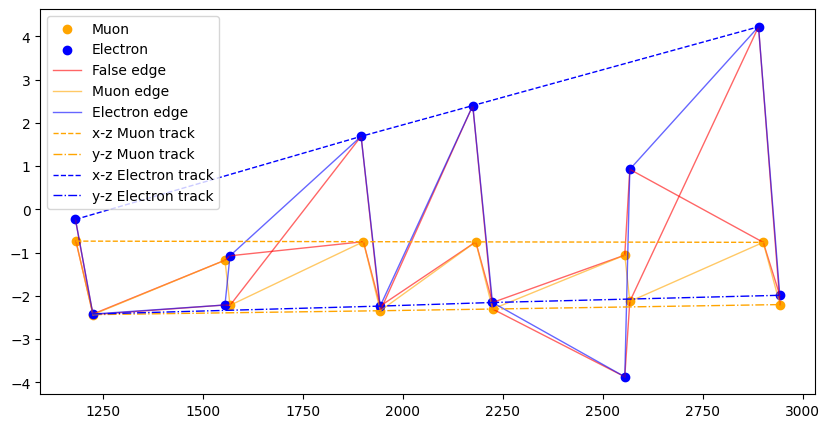

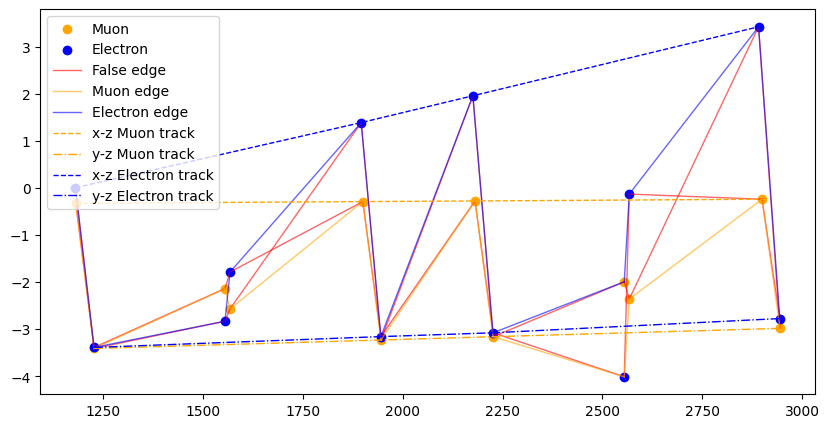

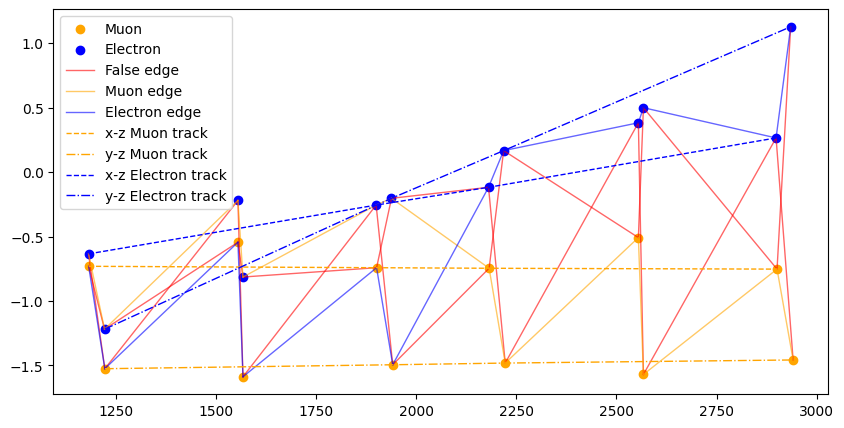

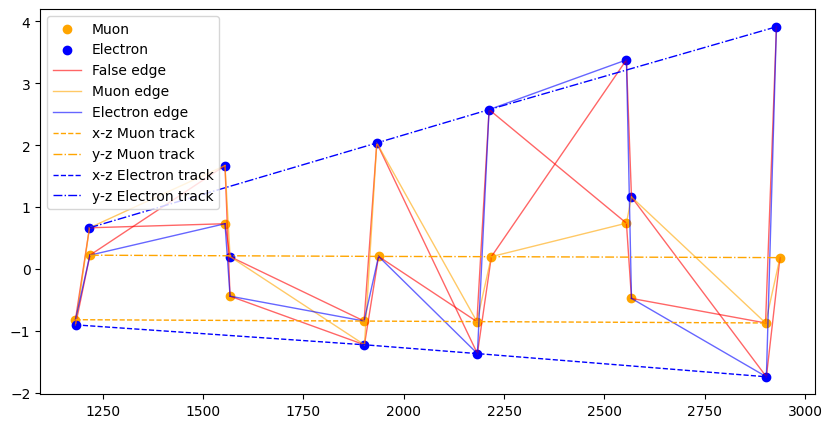

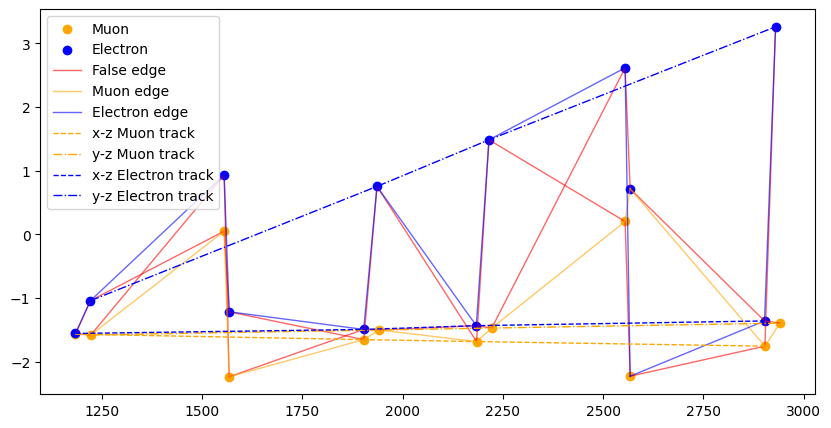

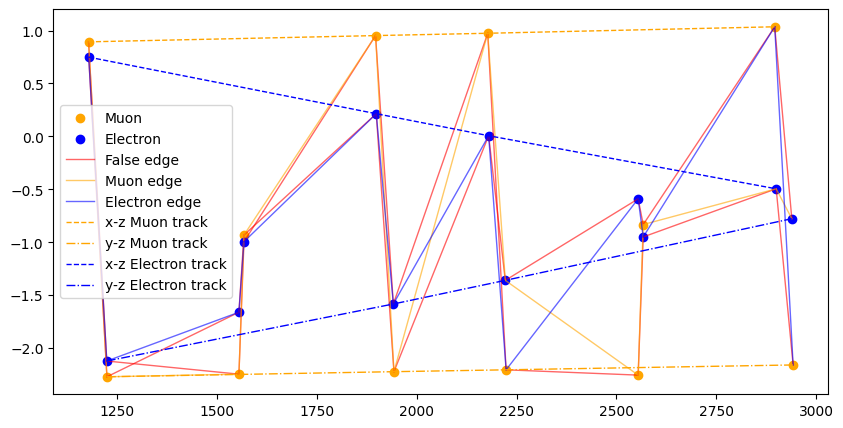

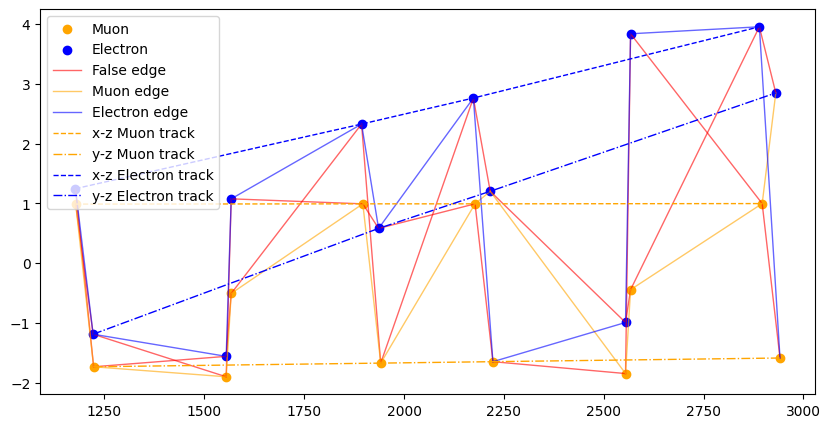

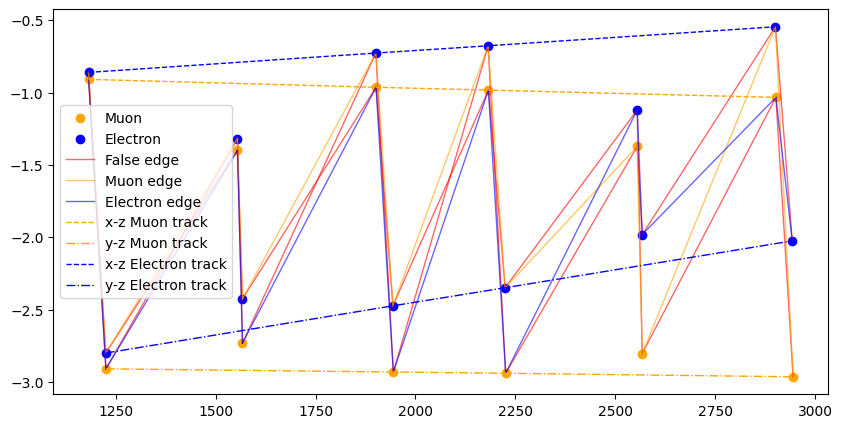

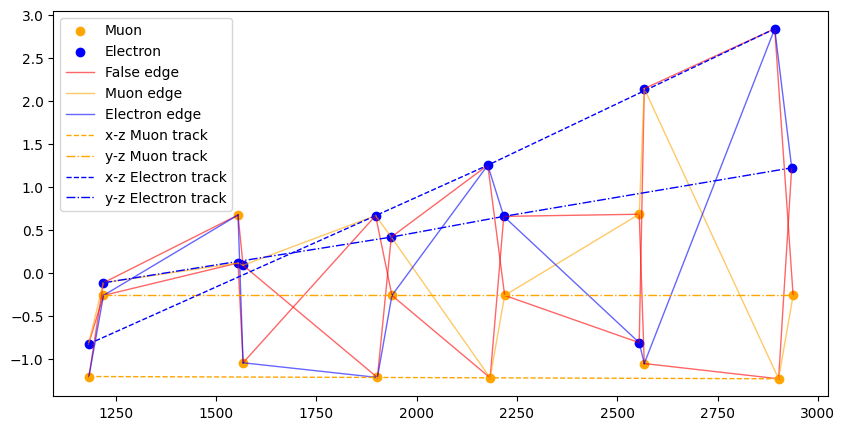

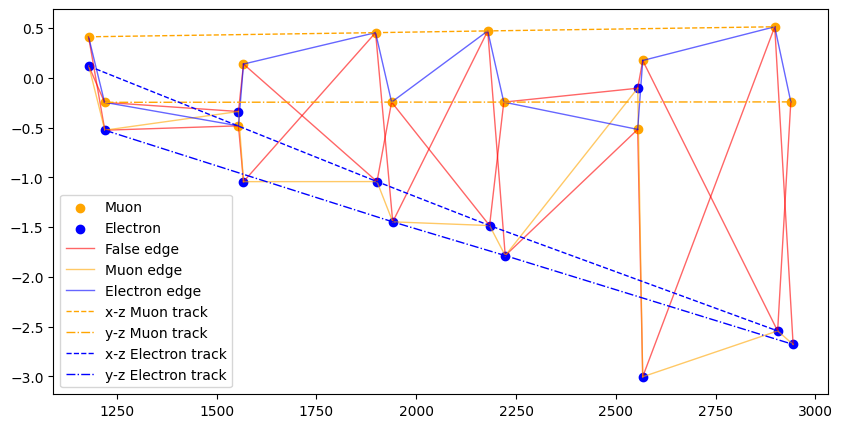

In [8]:
NUMBER_OF_EVENT_PLOTS = 10

def plot_event(event, print_data=False):
    
    if print_data:
        print("Event x:", event.x)
        print("Event edge_index:", event.edge_index)
        print("Event labels (y):", event.y)
        print("Event pid:", event.pid)
    
    plt.figure(figsize=(10, 5))
    
    x_coords = event.x[:, 0].numpy()
    y_coords = event.x[:, 1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    pid = event.pid
    
    #scaling factor along Z-axis
    sc = 1000.

    # Plot hits
    plt.scatter(sc*x_coords[pid == 1], y_coords[pid == 1], c='orange', label='Muon')
    plt.scatter(sc*x_coords[pid == 2], y_coords[pid == 2], c='blue', label='Electron')
    
    negative_edge_indices = torch.nonzero(train_dataset[0].y[:, 0] == 1).squeeze().numpy()
    muon_edge_indices = torch.nonzero(train_dataset[0].y[:, 1] == 1).squeeze().numpy()
    electron_edge_indices = torch.nonzero(train_dataset[0].y[:, 2] == 1).squeeze().numpy()
    
    # Plot negative edges
    plt.plot([sc*x_coords[edges[0, negative_edge_indices[0]]], sc*x_coords[edges[1, negative_edge_indices[0]]]],
             [y_coords[edges[0, negative_edge_indices[0]]], y_coords[edges[1, negative_edge_indices[0]]]],
             c='red', linewidth=1, label='False edge', alpha=0.6)

    plt.plot([sc*x_coords[edges[0, negative_edge_indices[1:]]], sc*x_coords[edges[1, negative_edge_indices[1:]]]],
             [y_coords[edges[0, negative_edge_indices[1:]]], y_coords[edges[1, negative_edge_indices[1:]]]],
             c='red', linewidth=1, alpha=0.6)
    
    # Plot muon edges
    plt.plot([sc*x_coords[edges[0, muon_edge_indices[0]]], sc*x_coords[edges[1, muon_edge_indices[0]]]],
             [y_coords[edges[0, muon_edge_indices[0]]], y_coords[edges[1, muon_edge_indices[0]]]],
             c='orange', linewidth=1, label='Muon edge', alpha=0.6)

    plt.plot([sc*x_coords[edges[0, muon_edge_indices[1:]]], sc*x_coords[edges[1, muon_edge_indices[1:]]]],
             [y_coords[edges[0, muon_edge_indices[1:]]], y_coords[edges[1, muon_edge_indices[1:]]]],
             c='orange', linewidth=1, alpha=0.6)
    
    # Plot electron edges
    plt.plot([sc*x_coords[edges[0, electron_edge_indices[0]]], sc*x_coords[edges[1, electron_edge_indices[0]]]],
             [y_coords[edges[0, electron_edge_indices[0]]], y_coords[edges[1, electron_edge_indices[0]]]],
             c='blue', linewidth=1, label='Electron edge', alpha=0.6)

    plt.plot([sc*x_coords[edges[0, electron_edge_indices[1:]]], sc*x_coords[edges[1, electron_edge_indices[1:]]]],
             [y_coords[edges[0, electron_edge_indices[1:]]], y_coords[edges[1, electron_edge_indices[1:]]]],
             c='blue', linewidth=1, alpha=0.6)
    
    # Plot x-z and y-z fits
    fit_data = {
        'mu_x': ([], []),
        'mu_y': ([], []),
        'e_x':  ([], []),
        'e_y':  ([], [])
    }

    def append_fit_data(hit, label):
        fit_data[label][0].append(sc*hit[0].item())
        fit_data[label][1].append(hit[1].item())

    for pid_val, label_prefix in zip([1, 2], ['mu', 'e']):
        for hit in event.x[pid == pid_val]:
            layer = layer_type(z_scale * hit[0].item())
            if layer in ['x', 'y']:
                append_fit_data(hit, f"{label_prefix}_{layer}")

    styles = {
        'mu_x': ('orange', '--', 'x-z Muon track'),
        'mu_y': ('orange', '-.', 'y-z Muon track'),
        'e_x':  ('blue', '--', 'x-z Electron track'),
        'e_y':  ('blue', '-.', 'y-z Electron track')
    }

    for key, (color, linestyle, label) in styles.items():
        plt.plot(fit_data[key][0], fit_data[key][1], c=color, linewidth=1, linestyle=linestyle, label=label)
    
    plt.legend()
    plt.show()

for i in range(NUMBER_OF_EVENT_PLOTS):
    plot_event(train_loader.dataset[i])

### Model build

In [9]:
def train(model, train_loader, optimizer, weight):
    correct = 0
    total = 0
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)

        loss = F.cross_entropy(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
        
    acc = correct / total
    return acc, total_loss


def evaluate(model, test_loader, weight):
    correct = 0
    total = 0
    total_loss = 0
    
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.cross_entropy(pred.float(), data.y.float())
        total_loss += loss.item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
        
    acc = correct / total
    return acc, total_loss

In [10]:
def make_mlp(
    input_size,
    sizes,
    hidden_activation='ReLU',
    output_activation='ReLU',
    layer_norm=False,
):
    '''Construct an MLP with specified fully-connected layers.'''
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
        
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    
    # Hidden layers
    for i in range(n_layers - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i + 1]))
        layers.append(hidden_activation())
        
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
        
    return nn.Sequential(*layers)


class MPNN_Network(nn.Module):
    '''
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    '''

    def __init__(
        self,
        input_dim,
        hidden_node_dim,
        hidden_edge_dim,
        in_layers,
        node_layers,
        edge_layers,
        n_graph_iters=1,
        layer_norm=True,
    ):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim] * in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(
            2 * hidden_node_dim, [hidden_edge_dim] * edge_layers, layer_norm=layer_norm
        )

        # The node network computes new node features
        self.node_network = make_mlp(
            hidden_node_dim + hidden_edge_dim,
            [hidden_node_dim] * node_layers,
            layer_norm=layer_norm,
        )

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(
            2 * hidden_node_dim, [hidden_edge_dim, 3], output_activation=None
        )

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)

        return self.edge_classifier(clf_inputs).squeeze(-1)

In [11]:
weight = 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 128, "hidden_edge_dim": 256, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-5, amsgrad=True)

### Model learning

In [12]:
EPOCHS = 500 #500

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

start_time = time.time()
epoch_times = []

for epoch in range(EPOCHS):
    ep += 1
    
    epoch_start_time = time.time()
    
    model.train()
    t_acc, t_total_loss = train(model, train_loader, optimizer, weight)
    t_loss_v.append(t_total_loss)
    t_acc_v.append(t_acc)

    model.eval()
    v_acc, v_total_loss = evaluate(model, test_loader, weight)
    v_loss_v.append(v_total_loss)
    v_acc_v.append(v_acc)

    epoch_end_time = time.time()
    epoch_times.append(epoch_end_time - epoch_start_time)
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_time = avg_epoch_time * (EPOCHS - (epoch + 1))
    remaining_minutes, remaining_seconds = divmod(remaining_time, 60)
    
    clear_output(wait=True)
    print(f'Epoch: {ep}, Loss: {v_total_loss:.4f}, Accuracy: {v_acc:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s, Avg. Time/Epoch: {avg_epoch_time:.2f}s, Remaining Time: {remaining_minutes:.0f}min:{remaining_seconds:.0f}s')
    
end_time = time.time()
total_training_time = end_time - start_time
total_minutes, total_seconds = divmod(total_training_time, 60)

print(f'Total Training Time: {total_minutes:.0f}min:{total_seconds:.0f}s')
print(f'Test loss and accuracy: {evaluate(model, test_loader, weight)}')

Epoch: 500, Loss: 8.3438, Accuracy: 0.9902, Time: 7.16s, Avg. Time/Epoch: 13.74s, Remaining Time: 0min:0s
Total Training Time: 114min:30s
Test loss and accuracy: (0.9901902758681393, 8.343802765875807)


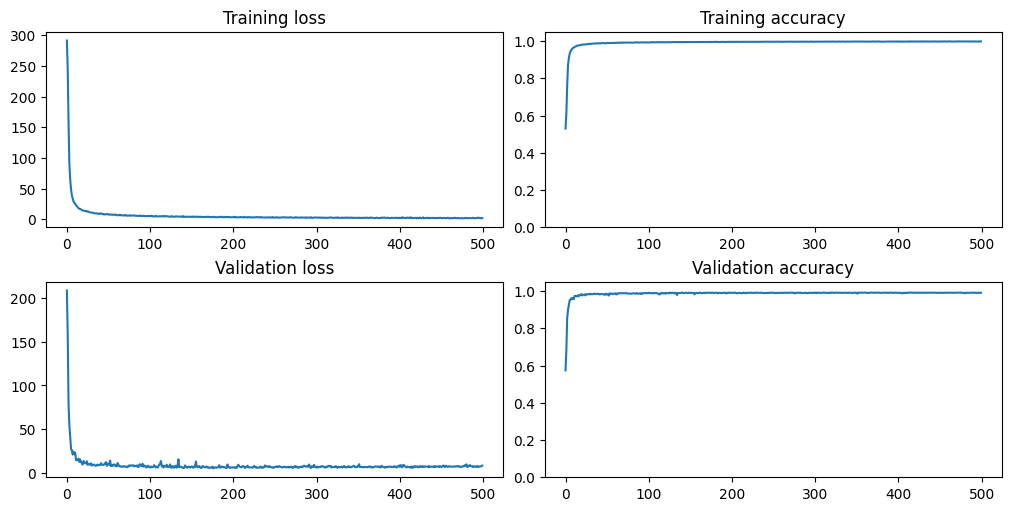

In [13]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10, 5))

data = [
    (np.arange(len(t_loss_v)), t_loss_v, "Training loss"),
    (np.arange(len(t_acc_v)), t_acc_v, "Training accuracy"),
    (np.arange(len(v_loss_v)), v_loss_v, "Validation loss"),
    (np.arange(len(v_acc_v)), v_acc_v, "Validation accuracy")
]

for ax, (x, y, title) in zip(axs.ravel(), data):
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_yscale("linear")
    if "accuracy" in title:
        ax.set_ylim(0, 1.05)

plt.show()

### Model save

In [14]:
model_path = './model_2024_08_10-ternary.pth'

# Save the model state dictionary
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Load the model state dictionary
# model.load_state_dict(torch.load(model_path))
# print(f'Model loaded from {model_path}')

Model saved to ./model_2024_08_10-ternary.pth


### Model evaluation

#### Classified events plots

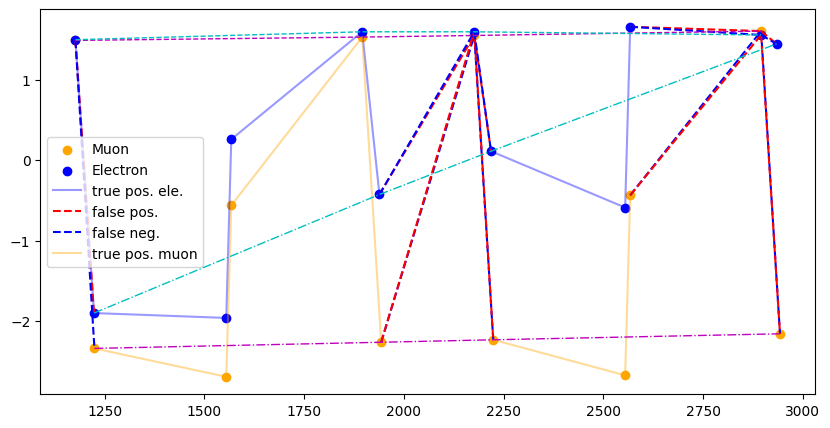

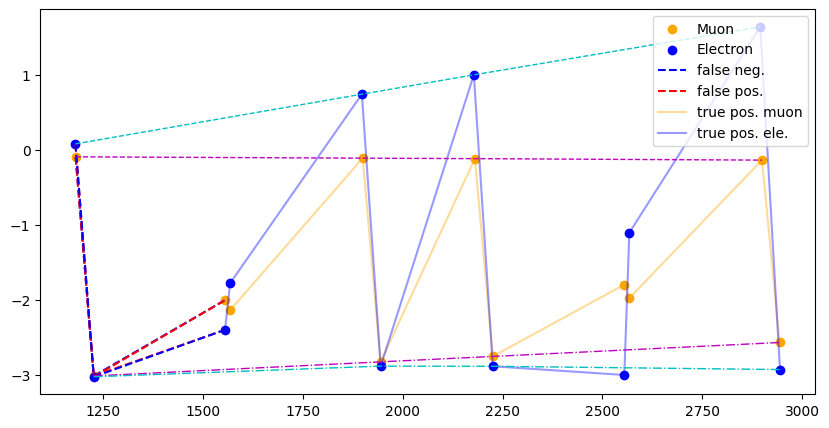

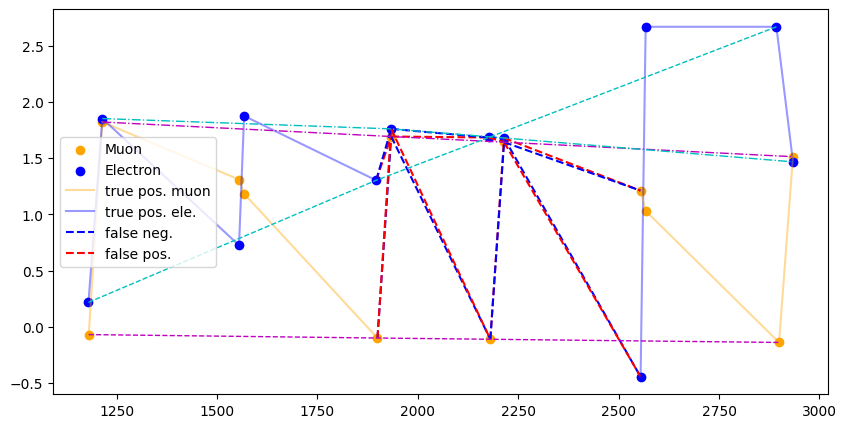

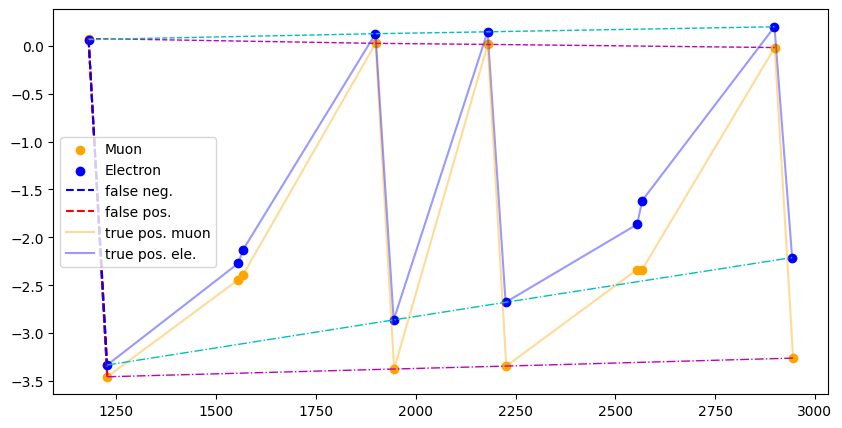

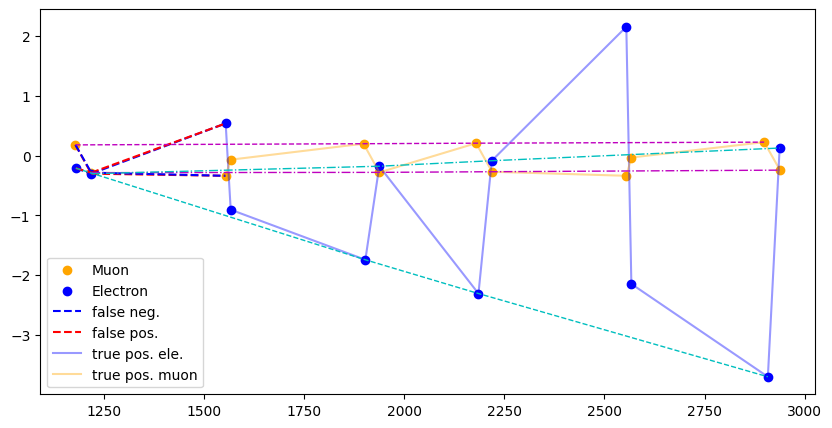

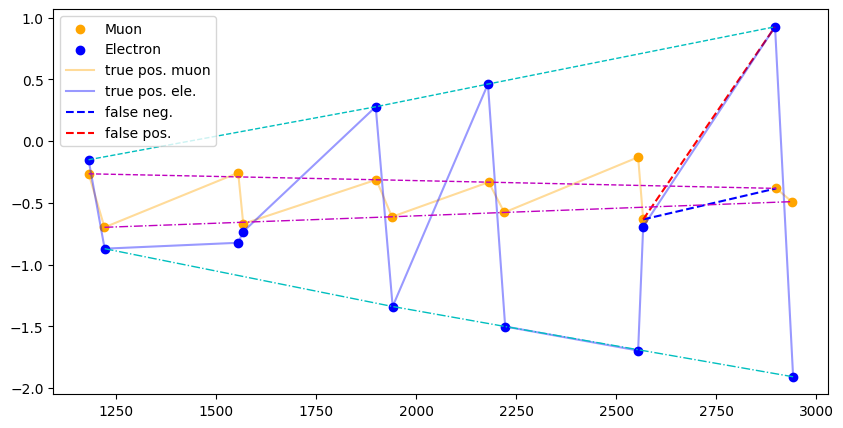

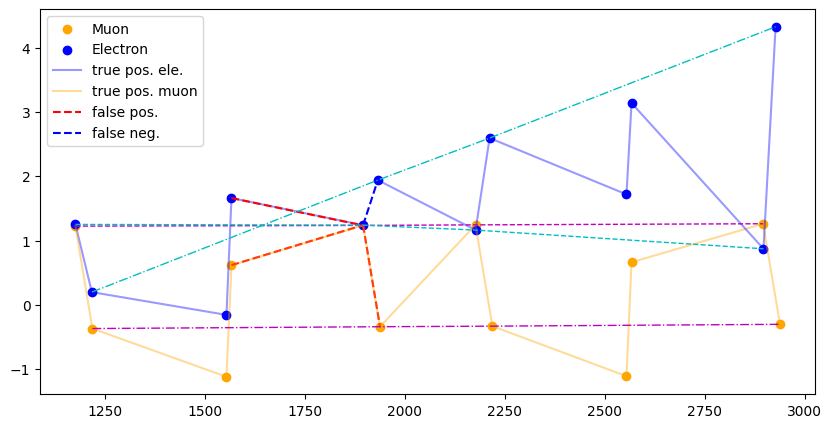

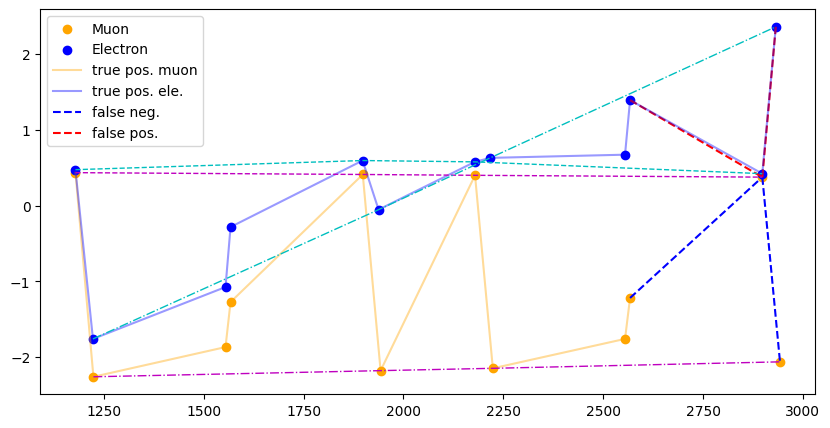

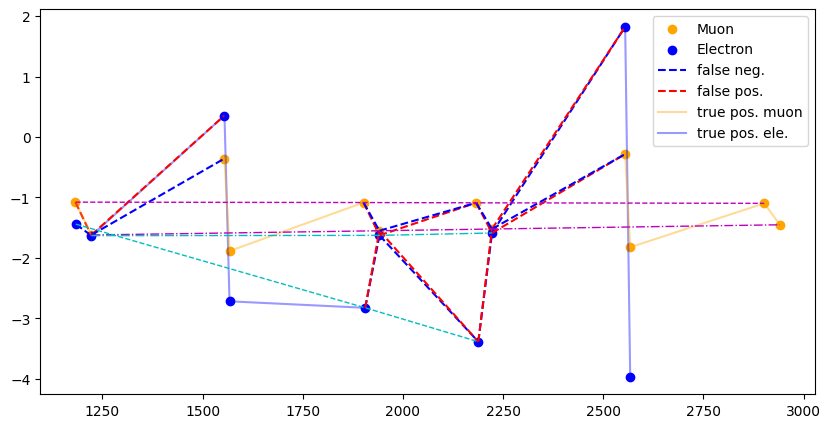

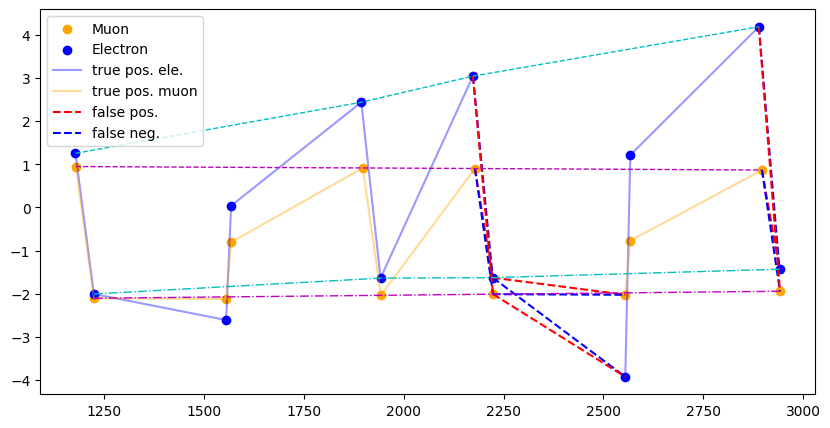

In [26]:
NUMBER_OF_CLASSIFIED_EVENT_PLOTS = 10
ERROR_ONLY = True
CUT = 0.5

def plot_classified_event(event, preds):
    
    plt.figure(figsize=(10, 5))
    
    x_coords = event.x[:, 0].numpy()
    y_coords = event.x[:, 1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    pid = event.pid
 
    #scaling factor along Z-axis
    sc = 1000.
   
    # Plot hits
    plt.scatter(sc*x_coords[pid == 1], y_coords[pid == 1], c='orange', label='Muon')
    plt.scatter(sc*x_coords[pid == 2], y_coords[pid == 2], c='blue', label='Electron')
    
    # Plot classified edges
    predicted_classes = preds.argmax(axis=1)
    true_classes = labels.argmax(axis=1)
    
    nfn, nfp, ntpm, ntpe = 0, 0, 0, 0
    for i in range(len(labels)):
        x_edge = [sc*x_coords[edges[0, i]], sc*x_coords[edges[1, i]]]
        y_edge = [y_coords[edges[0, i]], y_coords[edges[1, i]]]

        if predicted_classes[i] == 0 and true_classes[i] > 0:
            # False negatives
            plt.plot(x_edge, y_edge, '--', c='blue', label="false neg." if nfn==0 else None)
            nfn+=1
            
        elif predicted_classes[i] > 0 and true_classes[i] == 0:
            # False positives
            plt.plot(x_edge, y_edge, '--', c='red', alpha=1, label="false pos." if nfp==0 else None)
            nfp+=1
            
            # False positive – muon and electron scrambled
        elif (predicted_classes[i] == 1 and true_classes[i] == 2) \
                or (predicted_classes[i] == 2 and true_classes[i] == 1):
            plt.plot(x_edge, y_edge, ':', c='red', alpha=1, label="false pos." if nfp==0 else None)
            nfp+=1
            
        elif predicted_classes[i] == 1 and true_classes[i] == 1:
            # True positives – muon
            plt.plot(x_edge, y_edge, '-', c='orange', alpha=0.4, label="true pos. muon" if ntpm==0 else None)
            ntpm+=1
            
        elif predicted_classes[i] == 2 and true_classes[i] == 2:
            # True positives – electron
            plt.plot(x_edge, y_edge, '-', c='blue', alpha=0.4, label="true pos. ele." if ntpe==0 else None)
            ntpe+=1
            
#         elif predicted_classes[i] == 0 and true_classes[i] == 0:
#             # True negatives
#             plt.plot(x_edge, y_edge, '-', c='black')
    
    # Plot x-z and y-z fits
    fit_data = {
        'mu_x': ([], []),
        'mu_y': ([], []),
        'e_x':  ([], []),
        'e_y':  ([], [])
    }

    def append_fit_data(hit, label):
        fit_data[label][0].append(sc*hit[0].item())
        fit_data[label][1].append(hit[1].item())

    for pid_val, label_prefix in zip([1, 2], ['mu', 'e']):
        for hit in event.x[pid == pid_val]:
            layer = layer_type(z_scale * hit[0].item())
            if layer in ['x', 'y']:
                append_fit_data(hit, f"{label_prefix}_{layer}")

    styles = {
        'mu_x': ('m', '--'),
        'mu_y': ('m', '-.'),
        'e_x':  ('c', '--'),
        'e_y':  ('c', '-.')
    }

    for key, (color, linestyle) in styles.items():
        plt.plot(fit_data[key][0], fit_data[key][1], c=color, linewidth=1, linestyle=linestyle)
    
    plt.legend()
    plt.show()


# Plot a few events
events_plotted = 0
for i in range(len(test_loader.dataset)):
    event = test_loader.dataset[i].to(device)
    preds = torch.sigmoid(model(event)).to('cpu')

    if ERROR_ONLY:
        true_labels = event.y.cpu().argmax(dim=1)
        predicted_labels = preds.argmax(dim=1)
        if not torch.equal(true_labels, predicted_labels):
            plot_classified_event(event.to('cpu'), preds)
            events_plotted += 1
    else:
        plot_classified_event(event.to('cpu'), preds)
        events_plotted += 1
    
    if events_plotted >= NUMBER_OF_CLASSIFIED_EVENT_PLOTS:
        break

#### ROC curve and confusion matrix

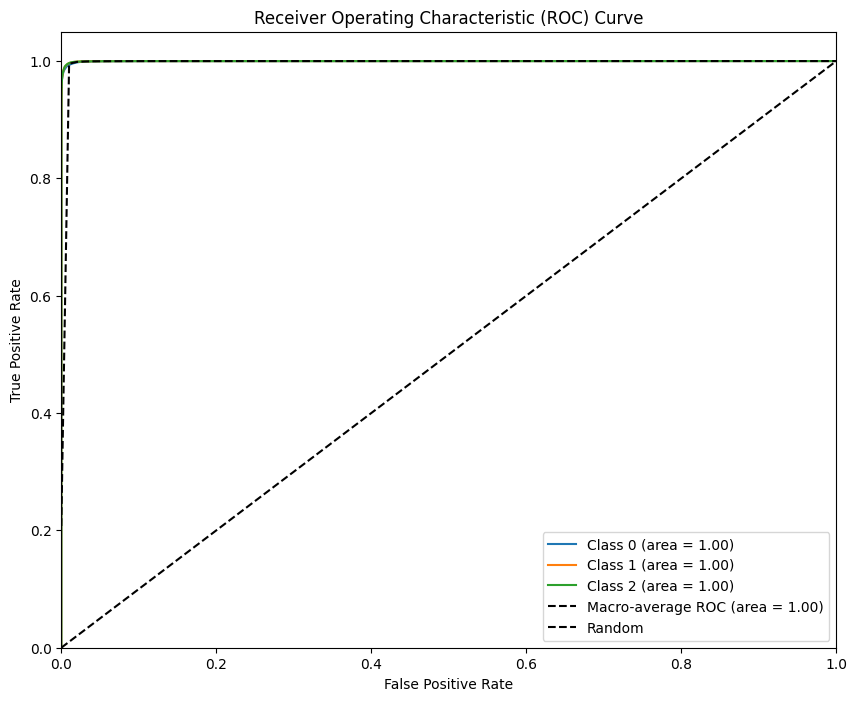

Macro-averaged AUC: 0.995899


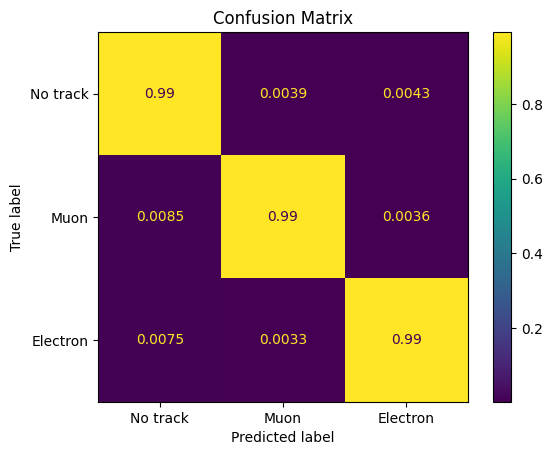

In [24]:
y_test = []
y_pred_proba = []

# Batch processing to save VRAM
model.eval()

# Need to send data to GPU needed after laoding from disk
model.to(device)
for data in test_loader.dataset:
    data.to(device)

with torch.no_grad():
    for batch in test_loader:
        inputs = batch.to(device)
        labels = batch.y.to(device).argmax(dim=1)
        
        logits = model(inputs)
        
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        
        y_pred_proba.append(probabilities.cpu())
        y_test.append(labels.cpu())

y_test = torch.cat(y_test).numpy()
y_pred_proba = torch.cat(y_pred_proba).numpy()

n_classes = y_pred_proba.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, 'k--', label=f'Macro-average ROC (area = {auc(all_fpr, mean_tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

macro_auc = auc(all_fpr, mean_tpr)
print(f'Macro-averaged AUC: {macro_auc:.6f}')

y_pred = np.argmax(y_pred_proba, axis=1)
cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No track","Muon","Electron"])
disp.plot()
plt.title('Confusion Matrix')
plt.show()